<img src="https://ethical-principles-in-ai.github.io/static/media/epai_logo.e502dc0cef3c434c1abf.png" width="100">

# Deep Learning with Differential Privacy: Base Model

This model provides a baseline for comparison between various differential privacy techniques. It uses the DP-SGD techqniue, as described in [Abadi et al.](https://arxiv.org/abs/1607.00133). Guassian noise is applied within SGD to ensure the model cannot be reverse engineered using inputs/outputs, which makes the model differientially private.

*Written by Nicole Streltsov February - March 2023*

In [1]:
#check that we are on the correct python kernel 
from platform import python_version
print(python_version())

3.9.16


In [2]:
# imports
!pip --quiet install  objax # only for google colab
!pip --quiet install memory_profiler # only for google colab
import jax
import jax.numpy as jn
import objax # to define a custom model with more control
import tensorflow as tf 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import gzip
import time
from memory_profiler import memory_usage
# Disable absl INFO and WARNING log messages
from absl import logging as absl_logging
absl_logging.set_verbosity(absl_logging.ERROR)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 KB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Data Load and Model Creation

In [3]:
def convert_x(x):
  '''helper function to convert numpy array to proper format'''
  return x.transpose(0, 3, 1, 2) / 255.0 # normalize, and ensure correct indicies for model

def load_from_pickle_files(prefix, path=''):
  '''helper function to load pickle files and return the numpy arrays we need'''
  with gzip.open(os.path.join(path, prefix + '_x_train.gz'), 'rb') as i:
      x_train = pickle.load(i)
  with gzip.open(os.path.join(path, prefix + '_x_val.gz'), 'rb') as i:
      x_valid = pickle.load(i)    
  with gzip.open(os.path.join(path, prefix + '_x_test.gz'), 'rb') as i:
      x_test = pickle.load(i)  
  with gzip.open(os.path.join(path, prefix + '_y_train.gz'), 'rb') as i:
      y_train = pickle.load(i)  
  with gzip.open(os.path.join(path, prefix + '_y_val.gz'), 'rb') as i:
      y_valid = pickle.load(i) 
  with gzip.open(os.path.join(path, prefix + '_y_test.gz'), 'rb') as i:
      y_test = pickle.load(i) 
    
  x_train = convert_x(x_train)
  y_train = y_train.flatten()

  x_valid = convert_x(x_valid)
  y_valid = y_valid.flatten()

  x_test = convert_x(x_test)
  y_test = y_test.flatten()

  print("numpy array shapes --> ", x_train.shape, x_valid.shape, x_test.shape, y_train.shape, y_valid.shape, y_test.shape)

  return x_train, x_valid, x_test, y_train, y_valid, y_test         

In [17]:
# load datasets

#variables that determine if the dataset should be run
chest_data = True
knee_data  = True

if chest_data:
  print("loading chest data ...")
  x_train_c, x_valid_c, x_test_c, y_train_c, y_valid_c, y_test_c = load_from_pickle_files('chest')
if knee_data:
  print("loading knee data ...")
  x_train_k, x_valid_k, x_test_k, y_train_k, y_valid_k, y_test_k = load_from_pickle_files('knee')

loading chest data ...
numpy array shapes -->  (6808, 3, 64, 64) (586, 3, 64, 64) (585, 3, 64, 64) (6808,) (586,) (585,)
loading knee data ...
numpy array shapes -->  (12935, 3, 64, 64) (826, 3, 64, 64) (826, 3, 64, 64) (12935,) (826,) (826,)


In [18]:
# define cnn
class CNN(objax.Module):
  def __init__(self, channels, classes, size, kernel=3):
    self.conv1 = objax.nn.Sequential([objax.nn.Conv2D(channels, size, kernel), objax.functional.relu])
    self.conv2 = objax.nn.Sequential([objax.nn.Conv2D(size, 32, kernel), objax.functional.relu])
    self.fc1 = objax.nn.Sequential([objax.nn.Linear(8192, 64*classes), objax.functional.relu]) #128
    self.fc2 = objax.nn.Linear(64*classes, classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv1(x), 2, 2)
    x = objax.functional.max_pool_2d(self.conv2(x), 2, 2)
    x = objax.functional.flatten(x)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

samples for chest data:
samples for knee data:


<Figure size 432x288 with 0 Axes>

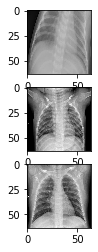

<Figure size 432x288 with 0 Axes>

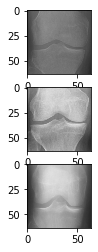

In [19]:
# show preview of dataset images
def show_3_samples(x_train, x_valid, x_test):
  plt.figure()
  f, axarr = plt.subplots(3,1) 
  axarr[0].imshow(x_train[0].transpose(1,2,0))
  axarr[1].imshow(x_valid[0].transpose(1,2,0))
  axarr[2].imshow(x_test[0].transpose(1,2,0))

if chest_data:
  print("samples for chest data:")
  show_3_samples(x_train_c, x_valid_c, x_test_c)
if knee_data:
  print("samples for knee data:")
  show_3_samples(x_train_k, x_valid_k, x_test_k)

## Helper Functions

In [20]:
#training loop helper function
def train_per_batch(x, y, lr, batch, train_op, predict):
  acc = 0
  shuffle_indicies = np.arange(len(x))
  np.random.shuffle(shuffle_indicies) #shuffle before running batches to remove correlation

  for i in range(0, x.shape[0], batch):
      batch_idxs = shuffle_indicies[i:i+batch]

      #run train_op step
      loss = float(train_op(x[batch_idxs], y[batch_idxs], lr)[0]) * len(batch_idxs)
      
      #store accuracy
      acc += (np.array(predict(x[batch_idxs]).argmax(1)).flatten() == y[batch_idxs]).sum()

  return acc

#training loop
def train(epochs, batch, lr, x_train, x_valid, y_train, y_valid, train_op, predict):
  train_accuracies = []
  valid_accuracies = []
  epsilons = []

  for epoch in range(1, epochs+1):
      train_loss = []
      valid_loss = []

      # batch training
      avg_train_acc = train_per_batch(x_train, y_train, lr, batch, train_op, predict) / x_train.shape[0]
      train_accuracies.append(avg_train_acc)
      
      # batch validation 
      avg_val_acc = train_per_batch(x_valid, y_valid, lr, batch, train_op, predict) / x_valid.shape[0]
      valid_accuracies.append(avg_val_acc)

      print('Epoch %d  Training Accuracy %.4f Validation Accuracy %.4f' % (epoch, avg_train_acc*100, avg_val_acc*100))
  
  return train_accuracies, valid_accuracies

In [21]:
# show plot helper function
def show_plot(train_accuracies, valid_accuracies, dataset, cnn_type):
  title = "Training and Validation Accuracies of "+ cnn_type + " CNN for " + dataset + " data"
  plt.title(title)
  plt.plot(train_accuracies, label="Train")
  plt.plot(valid_accuracies, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

In [22]:
# test accuracy helper function
def get_test_accuracy(predict, x_test, y_test, dataset, cnn_type):
  test_accuracy = (np.array(predict(x_test).argmax(1)).flatten() == y_test).sum()
  print("Test Accuracy of ", cnn_type, " Model for ", dataset, " data: ", 100*test_accuracy/x_test.shape[0])
  return 100*test_accuracy/x_test.shape[0]

In [23]:
!pip --quiet install tensorflow-privacy #for google colab
def get_epsilon_momentents_gaussian_dp(num_train_data, noise_multiplier, num_epochs, batch_size):
  '''
  calculates epsilon (ε) of the differentially private model. The model is said to be ε-differentially private if the model cannot differentiate 
  between two datasets that differ by one point. 

  @param num_training_data (int): the number of training examples
  @param noise_multiplier (double): standard deviation of the gaussian noise added to the gradients 
  @param num_epochs (int): number of epochs the model ran for
  @param batch_size (int): batch size used
  @returns epsilon(int) : epsilon value

  NOTE - to disable warning messages add this: 
    from absl import logging as absl_logging
    absl_logging.set_verbosity(absl_logging.ERROR)
  '''
  from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy_lib
  delta = 1e-5 #typical value for delta 

  # compute the privacy budget
  epsilon, __ = compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy(
      n=num_train_data,
      batch_size=batch_size,
      noise_multiplier=noise_multiplier,
      epochs=num_epochs,
      delta=delta,
  )
  return epsilon

In [24]:
def get_memory_usage_and_runtime(train_function, arguments):
    '''
    gets peak memory usage of the training function in MB and runtime in seconds
    
    @param train_function: the model's training loop
    @param arguments: tuple of arguments for the function
    @return runtime (s), peak_mem (MB), result (return of the function)

    NOTE - if the function has no return values or arguments, run it like this: 
    mem = memory_usage(proc=train_function)
    '''

    s = time.time()
    mem, result = memory_usage((train_function, arguments), retval=True)
    e = time.time()
    runtime = e-s
    peak_mem = max(mem)
    
    return runtime, peak_mem, result

## Train Regular CNN

In [25]:
# hyperparameters
epochs = 100
lr = 0.01 #0.001
size = 64 #h/w of images in dataset

In [26]:
def define_model_and_train_regular(x_train, x_valid, y_train, y_valid, num_classes):
  ''' regular SGD'''

  #define model
  model_regular = CNN(channels = 3, classes = num_classes, size = size, kernel = 3) 

  #define loss
  def loss_fn_regular(x, y):
      return objax.functional.loss.cross_entropy_logits_sparse(model_regular(x), y).mean()

  #define prediction function (to get results of model training)
  predict_regular = objax.Jit(lambda x: objax.functional.softmax(model_regular(x)), model_regular.vars())

  # define 'forward' operation.
  gv_regular = objax.GradValues(loss_fn_regular, model_regular.vars()) #function that calculates gradient
  tv_regular = objax.ModuleList(objax.TrainRef(x) for x in model_regular.vars().subset(objax.TrainVar)) #trainable variables

  def train_op_regular(x, y, lr):
      g, v = gv_regular(x, y) # apply gradient
      
      # ** optimzer: SGD **
      for grad, params in zip(g, tv_regular.vars()):
        params.value -= jn.multiply(grad, lr) #jax speeds up computation

      return v # v is the loss

  train_op_regular = objax.Jit(train_op_regular, gv_regular.vars() + tv_regular.vars()) # compile train_op to make it faster

  train_accuracies_regular, valid_accuracies_regular = train(epochs, batch, lr, x_train, x_valid, y_train, y_valid, train_op_regular, predict_regular)

  return train_accuracies_regular, valid_accuracies_regular, predict_regular

In [27]:
# train without differential privacy (dp)
if chest_data:
  print("-----Training for chest x-ray data: ------")
  num_classes = 2
  batch = 100

  runtime_regular_c, peak_mem_regular_c, (train_accuracies_regular_c, valid_accuracies_regular_c, predict_regular_c) = get_memory_usage_and_runtime(define_model_and_train_regular, (x_train_c, x_valid_c, y_train_c, y_valid_c, num_classes))
  print ("Runtime(s): ", runtime_regular_c, "Memory(MB): ", peak_mem_regular_c)

if knee_data:
  print("-----Training for knee x-ray data: ------")
  num_classes = 5
  batch = 300

  runtime_regular_k, peak_mem_regular_k, (train_accuracies_regular_k, valid_accuracies_regular_k, predict_regular_k) = get_memory_usage_and_runtime(define_model_and_train_regular, (x_train_k, x_valid_k, y_train_k, y_valid_k, num_classes))
  print ("Runtime(s): ", runtime_regular_k, "Memory(MB): ", peak_mem_regular_k)

-----Training for chest x-ray data: ------
Epoch 1  Training Accuracy 72.1798 Validation Accuracy 74.4027
Epoch 2  Training Accuracy 81.9918 Validation Accuracy 83.1058
Epoch 3  Training Accuracy 88.1316 Validation Accuracy 83.4471
Epoch 4  Training Accuracy 91.7891 Validation Accuracy 91.8089
Epoch 5  Training Accuracy 93.2726 Validation Accuracy 92.4915
Epoch 6  Training Accuracy 94.1539 Validation Accuracy 94.5392
Epoch 7  Training Accuracy 94.7268 Validation Accuracy 91.4676
Epoch 8  Training Accuracy 95.4612 Validation Accuracy 93.0034
Epoch 9  Training Accuracy 95.5053 Validation Accuracy 94.5392
Epoch 10  Training Accuracy 95.6522 Validation Accuracy 94.5392
Epoch 11  Training Accuracy 96.2103 Validation Accuracy 93.6860
Epoch 12  Training Accuracy 96.0488 Validation Accuracy 95.9044
Epoch 13  Training Accuracy 96.3132 Validation Accuracy 95.2218
Epoch 14  Training Accuracy 96.2544 Validation Accuracy 96.0751
Epoch 15  Training Accuracy 96.5629 Validation Accuracy 95.9044
Epoch 

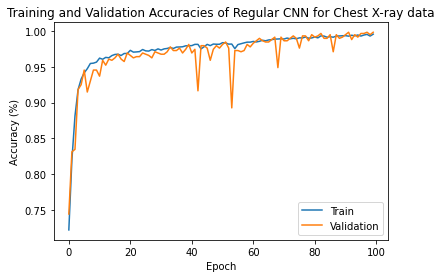

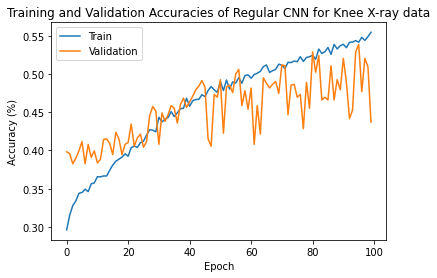

In [28]:
if chest_data:
  show_plot(train_accuracies_regular_c, valid_accuracies_regular_c, "Chest X-ray", "Regular")
if knee_data:
  show_plot(train_accuracies_regular_k, valid_accuracies_regular_k, "Knee X-ray", "Regular")

In [29]:
if chest_data:
  test_accuracy_regular_c = get_test_accuracy(predict_regular_c, x_test_c, y_test_c, 'Chest X-ray', "Regular")
if knee_data:
  test_accuracy_regular_k = get_test_accuracy(predict_regular_k, x_test_k, y_test_k, 'Knee X-ray', "Regular")

Test Accuracy of  Regular  Model for  Chest X-ray  data:  97.94871794871794
Test Accuracy of  Regular  Model for  Knee X-ray  data:  47.09443099273608


## Train CNN with Differential Privacy

In train_op_dp, add gaussian noise and gradient clipping


In [30]:
# hyperparameters
epochs = 100
lr = 0.01
size = 64 #h/w of images in dataset
sigma = 4 # noise scale
C = 80 # gradient norm (Best C = median of the norms of the unclipped gradients) - mean was 79.5 after running with C=100

In [31]:
def define_model_and_train_dp(x_train, x_valid, y_train, y_valid, num_classes):
  
  #last hyperparamter definition
  L = int(np.sqrt(len(x_train))) # L = √ N is the best group size

  #define model
  model_dp = CNN(channels = 3, classes = num_classes, size = size, kernel = 3)

  #define loss
  def loss_fn_dp(x, y):
      return objax.functional.loss.cross_entropy_logits_sparse(model_dp(x), y).mean()

  #define prediction function (to get results of model training)
  predict_dp = objax.Jit(lambda x: objax.functional.softmax(model_dp(x)), model_dp.vars())

  # define 'forward' operation.
  gv_dp = objax.GradValues(loss_fn_dp, model_dp.vars()) #dictionary that stores gradients
  tv_dp = objax.ModuleList(objax.TrainRef(x) for x in model_dp.vars().subset(objax.TrainVar)) #trainable variables
  unclipped_grad = jn.arange(len(tv_dp.vars())*epochs) #store in list, to find best C

  def train_op_dp(x, y, lr):
      g, v = gv_dp(x, y) # apply gradient

      # ** optimzer: DP-SGD **

      i = 0 # which model variable
      for grad, params in zip(g, tv_dp.vars()):

        # get random "lot (L)" of examples to add noise to:
        lot_idxs = np.random.choice(len(x), L)
        g_lot, __ = gv_dp(x[lot_idxs], y[lot_idxs]) #get grad only for lot
        grad = g_lot[i]
      
        #gradient clipping
        norm = jn.linalg.norm(grad)
        unclipped_grad.at[i].set(norm) #store unlcipped gradients
        grad_clipped = grad / jn.maximum(jn.empty(jn.shape(norm)) + 1, norm/C)

        #apply guassian
        mu = 0
        std = sigma
        key = jax.random.PRNGKey(1) # to ensure guassian stays the same for all runs
        guassian = mu + std * jax.random.normal(key, jn.shape(grad_clipped))
        grad_w_guassian = jn.multiply(1/L, jn.add(grad_clipped, guassian))
        
        #update params
        params.value -= jn.multiply(grad_w_guassian, lr) 

        i+=1

      return v # v is the loss

  train_op_dp = objax.Jit(train_op_dp, gv_dp.vars() + tv_dp.vars()) # compile train_op to make it faster

  train_accuracies_dp, valid_accuracies_dp = train(epochs, batch, lr, x_train, x_valid, y_train, y_valid, train_op_dp, predict_dp)

  print ("---- For hyperparameter tuning: ----")
  print("mean of unclipped gradients -> ", jn.mean(unclipped_grad))

  return train_accuracies_dp, valid_accuracies_dp, predict_dp

In [43]:
# train with differential privacy
if chest_data:
  print("-----Training for chest x-ray data: ------")
  num_classes = 2
  batch = 100

  runtime_dp_c, peak_mem_dp_c, (train_accuracies_dp_c, valid_accuracies_dp_c, predict_dp_c) = get_memory_usage_and_runtime(define_model_and_train_dp, (x_train_c, x_valid_c, y_train_c, y_valid_c, num_classes))
  epsilon_c = get_epsilon_momentents_gaussian_dp(len(x_train_c), sigma, epochs, batch)
  print("epsilon_c: ", epsilon_c)
  print("Runtime(s): ", runtime_dp_c, "Memory(MB): ", peak_mem_dp_c)

if knee_data:
  print("-----Training for knee x-ray data: ------")
  num_classes = 5
  batch = 300

  runtime_dp_k, peak_mem_dp_k, (train_accuracies_dp_k, valid_accuracies_dp_k, predict_dp_k) = get_memory_usage_and_runtime(define_model_and_train_dp, (x_train_k, x_valid_k, y_train_k, y_valid_k, num_classes))
  epsilon_k = get_epsilon_momentents_gaussian_dp(len(x_train_k), sigma, epochs, batch)
  print("epsilon_k: ", epsilon_k)
  print("Runtime(s): ", runtime_dp_k, "Memory(MB): ", peak_mem_dp_k)

-----Training for chest x-ray data: ------
Epoch 1  Training Accuracy 64.1011 Validation Accuracy 71.6724
Epoch 2  Training Accuracy 67.0388 Validation Accuracy 61.2628
Epoch 3  Training Accuracy 62.4706 Validation Accuracy 62.9693
Epoch 4  Training Accuracy 61.6334 Validation Accuracy 69.1126
Epoch 5  Training Accuracy 66.5981 Validation Accuracy 72.5256
Epoch 6  Training Accuracy 71.6510 Validation Accuracy 77.6451
Epoch 7  Training Accuracy 76.8361 Validation Accuracy 81.2287
Epoch 8  Training Accuracy 79.7738 Validation Accuracy 84.1297
Epoch 9  Training Accuracy 81.4924 Validation Accuracy 83.4471
Epoch 10  Training Accuracy 82.1533 Validation Accuracy 84.3003
Epoch 11  Training Accuracy 83.3872 Validation Accuracy 85.4949
Epoch 12  Training Accuracy 83.7838 Validation Accuracy 83.2765
Epoch 13  Training Accuracy 84.4301 Validation Accuracy 84.1297
Epoch 14  Training Accuracy 85.1498 Validation Accuracy 85.1536
Epoch 15  Training Accuracy 85.2233 Validation Accuracy 86.6894
Epoch 

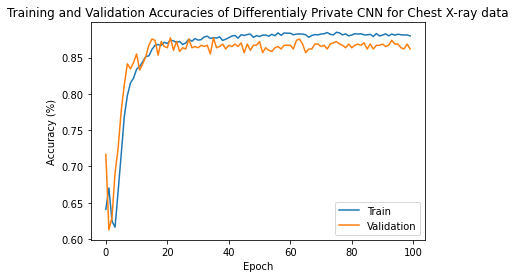

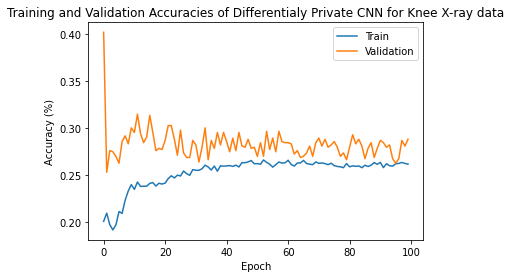

In [44]:
# plot accuracies from differentially private runs:
if chest_data:
  show_plot(train_accuracies_dp_c, valid_accuracies_dp_c, "Chest X-ray", "Differentialy Private")
if knee_data:
  show_plot(train_accuracies_dp_k, valid_accuracies_dp_k, "Knee X-ray", "Differentialy Private")

In [45]:
# test accuracies:
if chest_data:
  test_accuracy_dp_c = get_test_accuracy(predict_dp_c, x_test_c, y_test_c, 'Chest X-ray', "Differentialy Private")
if knee_data:
  test_accuracy_dp_k = get_test_accuracy(predict_dp_k, x_test_k, y_test_k, 'Knee X-ray', "Differentialy Private")

Test Accuracy of  Differentialy Private  Model for  Chest X-ray  data:  85.8119658119658
Test Accuracy of  Differentialy Private  Model for  Knee X-ray  data:  29.661016949152543


## Save the Metrics

In [48]:
def dump_metrics_to_json(filename, runtime, peak_mem, test_accuracy, epsilon=0, is_dp=False):
    '''
    dumps all the metrics from the model to a text file with the name filename

    @param filename (string): filename, must end with .txt
    @param runtime (float): runtime of training in seconds
    @param peak_mem (float): peak memory of training in MB
    @param epsilon (float): epsilon from gaussian DP
    @param is_dp (boolean): true if the model had differential privacy incorporated
    '''
    
    if is_dp:
        privacy_utility = epsilon/test_accuracy
        metrics = f"Runtime(s): {runtime}\nPeak Mem(MB): {peak_mem}\nTest Accuracy: {test_accuracy}\nEpsilon: {epsilon}\nUtility: {privacy_utility}"
    else:
        metrics = f"Runtime(s): {runtime}\nPeak Mem(MB): {peak_mem}\nTest Accuracy: {test_accuracy}"

    with open(filename, 'w') as f:
        f.write(metrics)

In [49]:
if chest_data:
  dump_metrics_to_json("tf_objax_regular_SGD_chest.txt", runtime_regular_c, peak_mem_regular_c, test_accuracy_regular_c,)
  dump_metrics_to_json("tf_objax_DP_SGD_chest.txt", runtime_dp_c, peak_mem_dp_c, test_accuracy_dp_c, epsilon_c, is_dp=True)
if knee_data:
  dump_metrics_to_json("tf_objax_regular_SGD_knee.txt", runtime_regular_k, peak_mem_regular_k, test_accuracy_regular_k)
  dump_metrics_to_json("tf_objax_DP_SGD_knee.txt", runtime_dp_k, peak_mem_dp_k, test_accuracy_dp_k, epsilon_k, is_dp=True)